# Hyperspectral Imaging

## Machine Learning and Computational Statistics, MSc in Data Science (2023/2024)
### Project Assignment

---

> Dimitris Tsirmpas <br>
> MSc in Data Science f3352315 <br>
> Athens University of Economics and Business

## Exploratory Analysis

We begin by importing the data. Our data is split in two files:

- `PaviaU_cube.mat`, which depicts the pixels for each image (300x200 resolution) for each of the 103 spectral bands

- `PaviaU_ground_truth.mat` which contains the class labels (materials) for each pixel in the image.

In [1]:
import scipy.io as sio
import numpy as np
import scipy.optimize 
import matplotlib.pyplot as plt


pavia = sio.loadmat('data/PaviaU_cube.mat')
hsi = pavia['X'] #Pavia HSI : 300x200x103

ends = sio.loadmat('data/PaviaU_endmembers.mat') # Endmember's matrix: 103x9
endmembers = ends["endmembers"]

In [49]:
#Perform unmixing for the pixels corresponding to nonzero labels
ground_truth = sio.loadmat('data/PaviaU_ground_truth.mat')
labels = ground_truth['y']
labels.shape

(300, 200)

Each of the 9 materials contains different values for each spectral band. We can see those values in the plot below:

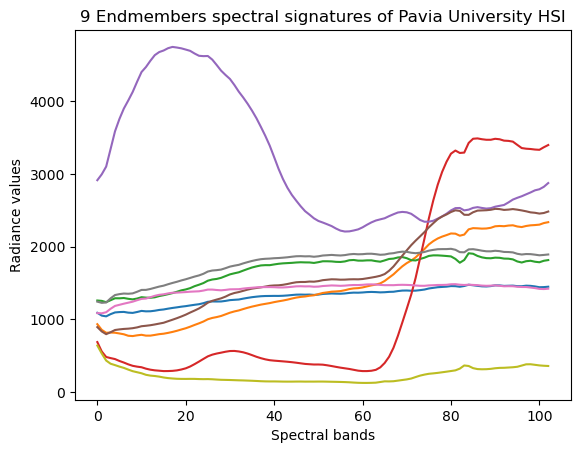

In [44]:
fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('9 Endmembers spectral signatures of Pavia University HSI')
plt.show()

These 9 endmembers represent 9 classes of materials, which can be seen in the dictionary below:

In [56]:
class_names = {
    0: "Mixed",
    1: "Water",
    2: "Trees",
    3: "Asphalt",
    4: "Self-Blocking Bricks",
    5: "Bitumen",
    6: "Tiles",
    7: "Shadows",
    8: "Meadows",
    9: "Bare Soil"
}

For this analysis, we need to only keep pure pixels, aka pixels that corresponds to geographical areas with a single geological feature. We thus split our dataset into "classless" aka mixed pixels, and pixels with defined class labels (pure pixels).

In [48]:
mask = labels != 0
pure_hsi = np.where(mask[:,:, None], hsi, 0)

(300, 200, 103)

In [5]:
mask = labels == 0
mixed_hsi = np.where(mask[:,:, None] , hsi, 0)

(300, 200, 103)

Since our data represent an image we can also show the image for a specific spectral band

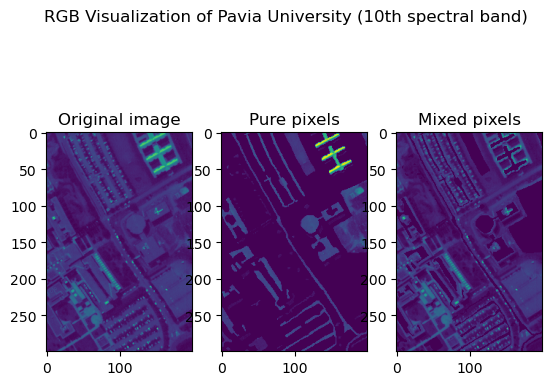

In [47]:
fig, axes = plt.subplots(1, 3)

axes[0].imshow(hsi[:,:,10])
axes[0].set_title("Original image")

axes[1].imshow(pure_hsi[:,:,10])
axes[1].set_title('Pure pixels')

axes[2].imshow(mixed_hsi[:,:,10])
axes[2].set_title('Mixed pixels')

fig.suptitle('RGB Visualization of Pavia University (10th spectral band)')
plt.show()

For demonstration purposes, let's select a pure pixel from the photograph. We select one of the pixels from the top right, from what looks like a building. This area of the photograph appears to have many continuous pure pixels, as seen by the Figure above.

In [57]:
focus_point = (32, 147)
print(f"Focus point is made of {class_names[labels[focus_point]]}")

Focus point is made of Bitumen


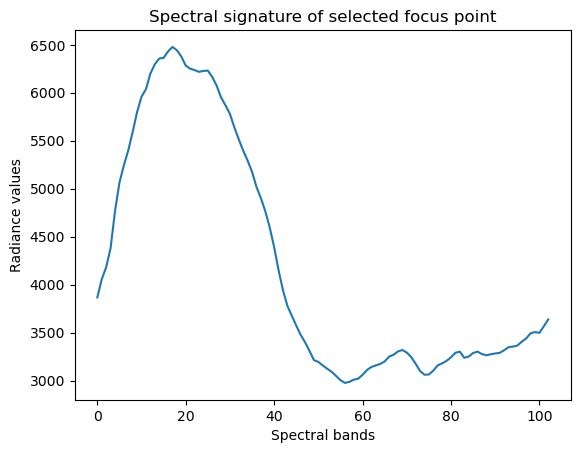

In [53]:
plt.plot(hsi[focus_point])
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title("Spectral signature of selected point")
plt.show()

Notice how similar this spectral signature is to the one defined in the graph above for pixels containing bitumen material.

## Spectral Unmixing

According to the *linear spectral unmixing hypothesis*, we can assume that every pixel ($y$) in our image is a linear combination of the various spectral signatures ($X$), where each spectral signature contributes a certrain percentage ($\theta$). Since all percentages must sum to one, this would make $\theta$ a *probability distribution function* (pdf), a property which would greately help in interpreting our results.

Under this assumption, the generating distribution for each pixel would be $y = X\theta + \eta, \eta \sim N(0, \sigma^2)$, where $\eta$ represents white noise. This model would be under the following constraints:
- No intercept (which would normally indicate a set % of an "other" material for all pixels)
- $\theta_i > 0, \forall i$
- $\sum_i \theta_i = 1$


We will be considering 4 models, each one following different constraints. Specifically, these will be:
1. An OLS model with no constraints
2. An OLS model with no intercept
3. An OLS model with no intercept and positive coefficients
4. An OLS model with no intercept and positive coefficients which sum to one
5. A LASSO model with no intercept and positive coefficients

Notice that out of the 5 models, only \#4 satisfies the prerequisitives of a pdf.

In [8]:
from prettytable import PrettyTable 


def arrays_stats(arrays: list[np.ndarray], names: list[str]|None = None, decimals: int = 2) -> PrettyTable:
    """
    Generate statistics for a list of NumPy arrays and create a PrettyTable.

    :param arrays: List of NumPy arrays for which statistics are calculated.
    :type arrays: list[np.ndarray]

    :param names: List of names corresponding to each array. If None, default names will be generated based on array indices. Default is None.
    :type names: list[str]|None

    :param decimals: Number of decimals to round the statistical values. Default is 2.
    :type decimals: int

    :return: Table containing statistics for each array, including mean, standard deviation, minimum, maximum, first quartile (Q1), and third quartile (Q3).
    :rtype: PrettyTable
    """
    stats_table = PrettyTable(["Array", "Shape", "Mean", "Std", "Min", "Max", "Q1", "Q3"])
    stats_table.float_format = "."+ decimals

    if type(decimals) is not int:
        raise ValueError("The 'decimals' argument must be an integer.")

    if names is None:
        names = [i for i in range(len(arrays))]

    if len(names) != len(arrays):
        raise ValueError("Names and arrays must have the same length.")

    for name, array in zip(names, arrays):
        stats_table.add_row([name, array.shape, array.mean(),  array.std(),  
                             array.min(), array.max(), 
                             np.quantile(array, 0.25), np.quantile(array, 0.75)])
    return stats_table

In [9]:
# our analysis only concerns pure pixels
y = pure_hsi
# reshape to 2 dimensions since OLS models require input of up to 2 dimensions
y1 = y.reshape(y.shape[2], (y.shape[0]*y.shape[1]))
x1 = endmembers

y1.shape, x1.shape

((103, 60000), (103, 9))

In [10]:
arrays_stats([y1, x1], names=["y1", "x1"])

Array,Shape,Mean,Std,Min,Max,Q1,Q3
y1,"(103, 60000)",337.71,746.75,0,6511,0.0,0.0
x1,"(103, 9)",1551.32,926.43,128.24,4745.65,1093.66,1897.79


We will also define some convinience functions to analyze the results of each model:

In [12]:
def abundance_matrix(coefficients: np.ndarray) -> np.ndarray:
    """
    Get the WxNxL abundance matrix from a model's (WxN)XL coefficients, where
    W is the image width, N is the image length, and L the image slices.
    """
    return coefficients.reshape((300, 200, 9))

In [13]:
def reconstruction_error(y: np.ndarray, X: np.ndarray, 
                         abundance_map: np.ndarray) -> float:
    """
    Get the reconstruction error for the pure pixels in the image.
    Essentially a Mean Squares Error wrapper for the problem's domain.
    """
    theta = abundance_map.reshape((60000, 9))
    return np.abs((y - X @ theta.T)).mean()

We will now define and run our models. We will then view and discuss the results in the next section.

### Ordinary Least Squares

In [14]:
from sklearn.linear_model import LinearRegression


base_model = LinearRegression(fit_intercept=True).fit(x1, y1)
base_abundance = abundance_matrix(base_model.coef_)
base_abundance[focus_point]

array([ 7.20899947, -1.42423256,  2.8208844 , -0.23192966,  0.47953866,
        1.8593963 , -9.67804554, -2.29280433, -3.46597145])

In [15]:
base_error = reconstruction_error(y1, x1, base_abundance)
base_error

7158.363577086339

### OLS no intercept, positive coefficients

In [16]:
pos_model = LinearRegression(fit_intercept=False, positive=True).fit(x1, y1)
pos_abundance = abundance_matrix(pos_model.coef_)
pos_abundance[focus_point]

array([0.        , 0.        , 0.08327632, 0.        , 0.05806055,
       0.        , 0.        , 0.        , 0.        ])

In [17]:
pos_error = reconstruction_error(y1, x1, pos_abundance)
pos_error

529.92719033652

### LASSO, no intercept, positive coefficients

In [18]:
from sklearn.linear_model import Lasso


lasso = Lasso(fit_intercept=False, positive=True, tol=1e-3, max_iter=int(1e5)).fit(x1, y1)
lasso_abundance = abundance_matrix(lasso.coef_)
lasso_abundance[focus_point]

array([0.        , 0.        , 0.08379727, 0.        , 0.05781112,
       0.        , 0.        , 0.        , 0.        ])

In [19]:
lasso_error = reconstruction_error(y1, x1, lasso_abundance)
lasso_error

529.954593992502

### OLS, no intercept, sum-to-one coefficients

In order to enforce the sum-to-one constraint we will build our own function using methods from the `scipy.optimize` module. While there are other solutions, these tend to either be very complicated and hard to modify for our needs (such as the `CVXOPT` package) or not work because of memory constraints / implementation bugs (in this case the `cvxpy` package).

Of note is that the current implementation needs to run a non-negative least squares and a coordinate descent with constraints routine for each one of our points, as the `nnls` function only supports vector calculations. This isn't as inefficient as it may sound, since the cost of the coordinate descent and non-negative least squares routines is proportionally much larger compared to the overhead of calling them for each point. 

Still, the calculation takes a lot of time (~10 minutes in a sufficiently powerful machine). We could speed it up by assigning each point's calculations to different threads, as the calculation is independent between them. However, we choose to keep the single-threaded code for the sake of clarity and simplicity.

In [20]:
from tqdm import tqdm
from scipy.optimize import minimize 
from scipy.optimize import nnls 


def lsq_sum_to_one(A: np.ndarray, b: np.ndarray, 
                    bounds :list[list[float|None]], 
                    verbose: bool=True) -> np.ndarray:
    """
    Solve a least squares optimization problem subject to the constraint that the
    sum of the coefficients in each column of the solution matrix is equal to 1.

    Parameters:
    - A (np.ndarray): The coefficient matrix.
    - b (np.ndarray): The target values matrix.
    - bounds (List[List[Union[float, None]]]): Bounds on variables for optimization.
      Each inner list represents the bounds for a corresponding variable.
      A value of None indicates no bound in that direction.
    - verbose (bool, optional): If True, display progress using tqdm. Default is True.

    Returns:
    - np.ndarray: The solution matrix where each column satisfies the sum-to-one constraint.
    """

    coefficients = np.zeros((A.shape[1], b.shape[1]))

    # define minimization function
    min_func = lambda x, A, b: np.linalg.norm(A.dot(x) - b)

    #Define constraints and bounds
    cons = {'type': 'eq', 'fun': lambda x:  np.sum(x)-1}

    iterable = tqdm(range(y1.shape[1])) if verbose else range(y1.shape[1])

    for i in iterable:
        bi = b[:, i]
        #Use nnls to get initial guess
        x0, rnorm = nnls(A, bi)

        #Call minimisation subject to these values
        minout = minimize(min_func, x0, args=(A, bi), method='SLSQP', 
                          bounds=bounds,constraints=cons)
        x = minout.x
        coefficients[:, i] = x

    return coefficients

In [21]:
sum1_coeffs = lsq_sum_to_one(x1, y1, 9*[[None, None]]).T

100%|############################################################################| 60000/60000 [11:26<00:00, 87.41it/s]


Let's confirm that our results do indeed sum up to one:

In [22]:
sum1_coeffs.shape, np.isclose(sum1_coeffs.sum(axis=1), 1).sum()

((60000, 9), 60000)

In [23]:
sum1_abundance = abundance_matrix(sum1_coeffs)
sum1_abundance[focus_point]

array([-10.44035101,  -0.29453926,  -1.50819246,  -0.56103416,
         0.40396393,   1.64938556,  -2.56364533,   9.14686077,
         5.16755196])

In [24]:
sum1_error = reconstruction_error(y1, x1, sum1_abundance)
sum1_error

505.18867736119023

### OLS, no intercept, positive and sum-to-one coefficients

In [25]:
pos_sum1_coeffs = lsq_sum_to_one(x1, y1, 9*[[0,None]]).T

100%|###########################################################################| 60000/60000 [05:27<00:00, 183.02it/s]


We can quickly check that our results satisfy the requirements of a pdf:

In [26]:
pos_sum1_coeffs.shape, np.isclose(pos_sum1_coeffs.sum(axis=1), 1, 1e-2).sum(), (pos_sum1_coeffs < 0).sum()

((60000, 9), 59281, 0)

There are a few rows which don't exactly add up to 1 (within $\pm 0.01$), which is expected since our algorithm is only approximate to our sum-to-one goal. Still, these deviations don't diverge as often or as enough for us to not count the resulting abundance map as a multi-dimensional pdf for each point.

In [27]:
pos_sum1_abundance = abundance_matrix(pos_sum1_coeffs)
pos_sum1_abundance[focus_point]

array([0.00000000e+00, 0.00000000e+00, 1.41684741e-10, 2.99027486e-12,
       2.06841795e-02, 0.00000000e+00, 3.81005631e-02, 0.00000000e+00,
       9.41215257e-01])

In [28]:
pos_sum1_error = reconstruction_error(y1, x1, pos_sum1_abundance)
pos_sum1_error

544.7215805692701

### Results

A table of the results for each model is presented below. Each row represents a different linear model, and the columns the reconstruction error, as well as the coefficients of the selected pixel we analyzed during the exploratory analysis.

In [43]:
def add_row(table, name, error, abundance):
    res_table.add_row([name, error, abundance[focus_point][0], abundance[focus_point][1],
                      abundance[focus_point][2], abundance[focus_point][3], abundance[focus_point][4],
                      abundance[focus_point][5], abundance[focus_point][6], abundance[focus_point][7],
                      abundance[focus_point][8]])


abundance_dim = 9
res_table = PrettyTable(["Model", "Reconstruction Error"] + [f"x{i}" for i in range(1, abundance_dim+1)])
res_table.float_format = ".3"

add_row(res_table, "OLS", base_error, base_abundance)
add_row(res_table, "OLS pos", pos_error, pos_abundance)
add_row(res_table, "LASSO pos", lasso_error, lasso_abundance)
add_row(res_table, "OLS sum-to-1", sum1_error, sum1_abundance)
add_row(res_table, "OLS pos sum-to-1", pos_sum1_error, pos_sum1_abundance)

res_table

Model,Reconstruction Error,x1,x2,x3,x4,x5,x6,x7,x8,x9
OLS,7158.364,7.209,-1.424,2.821,-0.232,0.480,1.859,-9.678,-2.293,-3.466
OLS pos,529.927,0.000,0.000,0.083,0.000,0.058,0.000,0.000,0.000,0.000
LASSO pos,529.955,0.000,0.000,0.084,0.000,0.058,0.000,0.000,0.000,0.000
OLS sum-to-1,505.189,-10.440,-0.295,-1.508,-0.561,0.404,1.649,-2.564,9.147,5.168
OLS pos sum-to-1,544.722,0.000,0.000,0.000,0.000,0.021,0.000,0.038,0.000,0.941


In [65]:
#print(f"Point {focus_point} contains " + ", ".join([f"{x*100:.2f}%" for x in pos_sum1_abundance[focus_point]]))

Point (32, 147) contains 0.00%, 0.00%, 0.00%, 0.00%, 5.55%, 0.00%, 0.00%, 0.00%, 94.45%


A number of observations can be made about our models:

1. The OLS model with no constraints does not lead to a good estimation.
1. The reconstruction error is lowest when we force the coefficients to sum to one, but not necessarily be positive.
1. The OLS with positive coefficients has almost identical results with the LASSO estimator, indicating our problem does not need any regularization. 
1. The OLS modeling a pdf (positive coefficients summing up to one) leads to a slightly larger error than the one without the positive constraint.

From these observations we conclude that:

The Linear Spectral Unmixing hypothesis seems to hold for our problem. This isn't surprising, since this hypothesis often holds and is widely used in practice `[1,2]`.

This conclusion is evident from the fact that our models generally become more efficient the more constraints we place on them, as well as from the fact that regularization appears uneccessary. This could be interpreted as selecting a very good prior for our regression problem, which effectively acts as an equivalent regualarization technique.

We can also trust that our pdf modeling approach is sufficient for our problem. We can thus use the estimates provided by our model to confidently model unmixed pixels in % terms of pure pixels.

`[1] Jiaojiao Wei, Xiaofei Wang, "An Overview on Linear Unmixing of Hyperspectral Data", Mathematical Problems in Engineering, vol. 2020, Article ID 3735403, 12 pages, 2020. https://doi.org/10.1155/2020/3735403`

`[2] Jan G.P.W. Clevers, Raul Zurita-Milla, 3 - Multisensor and multiresolution image fusion using the linear mixing model, Image Fusion, Academic Press, 2008, Pages 67-84, ISBN 9780123725295, https://doi.org/10.1016/B978-0-12-372529-5.00004-4 (https://www.sciencedirect.com/science/article/pii/B9780123725295000044)`

In [29]:
# Trainining set for classification 
Pavia_labels = sio.loadmat('classification_labels_Pavia.mat')
Training_Set = (np.reshape(Pavia_labels['training_set'],(200,300))).T
Test_Set = (np.reshape(Pavia_labels['test_set'],(200,300))).T
Operational_Set = (np.reshape(Pavia_labels['operational_set'],(200,300))).T

fig = plt.figure()
plt.imshow(Training_Set)
plt.title('Labels of the pixels of the training set')
plt.show()

<class 'FileNotFoundError'>: [Errno 2] No such file or directory: 'classification_labels_Pavia.mat'